<h2 style="display:inline;"> Turning </h2> 
<img src="img/pymc3.jpg" alt="pymc3_logo" style="width: 200px;display:inline;"/>
<h2 style="display:inline;"> into </h2>
<img src="img/sklearn.png" alt="sklearn_logo" style="width: 150px;display:inline;"/>

<h3>
Nicole Carlson <br>
@parsing_science <br>
github.com/parsing-science
</h3>

<h2> Overview </h2>
- Motivating Example: Scikitlearn Linear Regression
- Intro to PyMC3
- PyMC3 Linear Regression
- Compare Scikitlearn and PyMC3
- Implement Hiearchical Logistic Regression in PyMC3
- Use the Hierarchical Logistic Regression

In [1]:
import pickle

from matplotlib import pyplot as plt
import numpy as np
from pymc3 import summary, traceplot
import pymc3 as pm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import theano.tensor as T

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [3]:
plt.rcParams['figure.figsize'] = (15, 10)

plt.rcParams['font.size'] = 16

<h2>Motivating Example: Scikitlearn</h2>

<h2> Generate Fake Data </h2>

In [4]:
X = np.random.randn(1000, 1)
noise = 2 * np.random.randn(1000, 1)
Y = 4 * X + 3 + noise

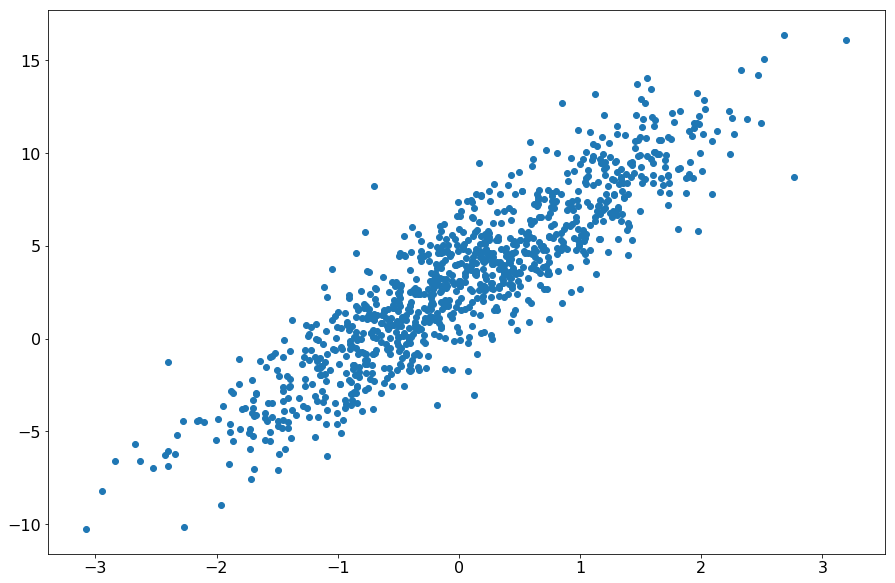

In [5]:
plt.scatter(X, Y)

<h2> Create a LinearRegression instance and use it </h2>

In [6]:
LR = LinearRegression()

In [7]:
LR.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [8]:
X_predict = LR.predict(X)

In [9]:
LR.score(X, Y)

0.80613292900134936

<h2> Save and Load LR </h2>

In [10]:
pickle.dump(LR, open('LR.pickle', 'wb'))

In [11]:
saved_LR = pickle.load(open('LR.pickle', 'rb'))

In [12]:
saved_LR.score(X, Y)

0.80613292900134936

<h2> Intro to PyMC3 </h2>

- Library for Probabilistic Modeling
- MCMC Samplers
- Variational Fitting Algorithms
- Built on top of Theano
- Completely written in Python

<h2> Using PyMC3 </h2>
- Step 1: Set up: Parameterize your model, choose priors, and insert training data
- Step 2: Inference: infer your parameters using sampling (e.g. NUTS) or variational inference (e.g. ADVI)
- Step 3: Interpret: Check your parameter distributions and model fit
- Step 4: Predict data: Create posterior samples with your inferred parameters

<h2> Step 1: Set up the PyMC3 model </h2>

In [13]:
lin_reg_model = pm.Model()
with lin_reg_model:

    alpha = pm.Normal('alpha', mu=0, tau=10.**-2, shape=(1))
    betas = pm.Normal('betas', mu=0, tau=10. ** -2, shape=(1))
    
    s = pm.HalfNormal('s', tau=1)
    
    temp = alpha + betas * X

    y = pm.Normal('y', mu=temp , tau=s ** -2, observed=Y)

<h2> Step 2: Infer your parameters </h2>

In [14]:
with lin_reg_model:
    step = pm.NUTS()
    nuts_trace = pm.sample(2e3, step)

100%|██████████| 2000/2000.0 [00:03<00:00, 572.71it/s]


<h2> Step 3: Interpret your parameters </h2>

In [15]:
summary(nuts_trace)


alpha:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  2.993            0.280            0.022            [2.886, 3.143]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  2.879          2.971          3.015          3.055          3.140


betas:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  3.973            0.390            0.032            [3.873, 4.123]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  3.877          3.960          4.005          4.048          4.129


s:

  Mean             SD               MC Error         95% HPD interval
  -----------------------------

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10e60b050>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10e859090>]], dtype=object)

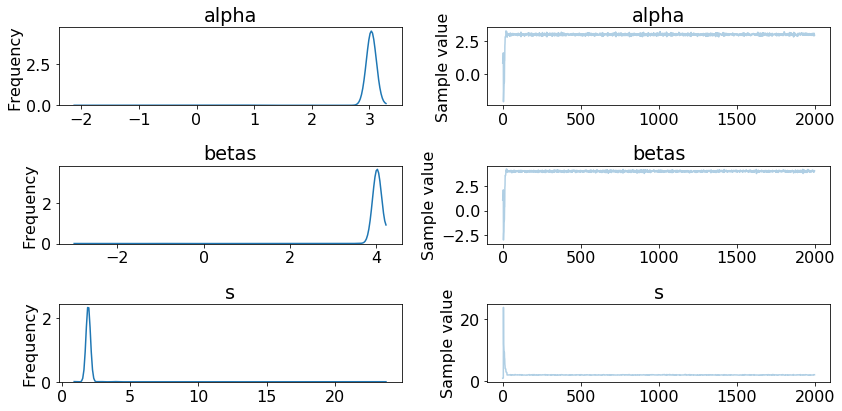

In [16]:
traceplot(nuts_trace)

<h2>Step 4: Predict data by creating posterior predictive samples </h2>

In [17]:
ppc = pm.sample_ppc(
    nuts_trace[1000:],
    model=lin_reg_model,
    samples=1000
)

100%|██████████| 1000/1000 [01:57<00:00, 10.66it/s]


In [18]:
pred = ppc['y'].mean(axis=0)

In [19]:
r2_score(Y, pred)

0.80553921760805347

<h2> Most PyMC3 Examples </h2>

* Exist in Jupyter notebooks
* Focus on training a model with one dataset
* Don’t demonstrate how to predict new data
* Don’t show how to save your model for later use



<h2> Comparing the two libraries </h2>

<table>
<tr>
<th> </th>
<th>sklearn</th>
<th>PyMC3</th>
</tr>
<tr>
<th>Find model parameters</th>
<th>Easy</th>
<th>Medium</th>
</tr>
<tr>
<th>Predict new data</th>
<th>Easy</th>
<th>Difficult</th>
</tr>
<tr>
<th>Score a model</th>
<th>Easy</th>
<th>Difficult</th>
</tr>
<tr>
<th>Save a trained model</th>
<th>Easy</th>
<th>Impossible?</th>
</tr>
<tr>
<th>Load a trained model</th>
<th>Easy</th>
<th>Impossible?</th>
</tr>
</table>


<h2> What we want to reproduce in PyMC3 </h2>

* fit
* predict
* score
* save
* load


<h2> Map between Scikitlearn and PyMC3 </h2>

<table>
<tr>
<th>sklearn</th>
<th>PyMC3</th>
</tr>
<tr>
<th>Fit</th>
<th>Step 1: Set up, Step 2: Inference</th>
</tr>
<tr>
<th>Predict</th>
<th>Step 4: Predict data</th>
</tr>
<tr>
<th>Score</th>
<th>Step 4: Predict data</th>
</tr>
<tr>
<th>Save/Load</th>
<th>??</th>
</tr>
<tr>
<th>??</th>
<th>Step 3: Interpret</th>
</tr>
</table>

<h2> Initializing the HLM class </h2>

In [ ]:
class HLM(BaseEstimator):
    """
    Custom Hierachical Linear Model built using PyMC3.
    """

    def __init__(self):
        self.cached_model = None
        self.shared_vars = None
        self.num_cats = None
        self.num_pred = None
        self.advi_trace = None
        self.v_params = None

<h2> Fit </h2>

In [ ]:
def fit(self, X, cats, y):
    """
    Train the HLM model

    Parameters
    ----------
    X : numpy array, shape [n_samples, n_features]

    cats: numpy array, shape [n_samples, ]

    y : numpy array, shape [n_samples, ]
    """
    self.num_cats = len(np.unique(cats))
    num_samples, self.num_pred = X.shape

    if self.cached_model is None:
        # Step 1: Set up the model
        self.cached_model, o = self.create_model()

    #Step 2: Inference
    minibatch_tensors = [
        self.shared_vars['model_input'],
        self.shared_vars['model_output'],
        self.shared_vars['model_cats']
    ]
    minibatch_RVs = [o]

    minibatches = self._create_minibatch([X, y, cats], num_samples)

    self.v_params, self.advi_trace = self._inference(
        minibatch_tensors,
        minibatch_RVs,
        minibatches,
        num_samples
    )

    return self

<h2> Step 1: Set up the model </h2>

In [ ]:
def create_model(self):
    """
    Creates and returns the PyMC3 model.

    Returns the model and the output variable. The latter is for use in ADVI minibatch.
    """
    model_input = theano.shared(np.zeros([1, self.num_pred]))

    model_output = theano.shared(np.zeros(1))

    model_cats = theano.shared(np.zeros(1, dtype='int'))

    self.shared_vars = {
        'model_input': model_input,
        'model_output': model_output,
        'model_cats': model_cats
    }

    model = pm.Model()

    with model:
        # Both alpha and beta are drawn from Normal distributions
        mu_alpha = pm.Normal("mu_alpha", mu=0, sd=10)
        sigma_alpha = pm.HalfNormal("sigma_alpha", sd=10)

        mu_beta = pm.Normal("mu_beta", mu=0, sd=10)
        sigma_beta = pm.HalfNormal("sigma_beta", sd=10)

        alpha = pm.Normal(
            'alpha',
            mu=mu_alpha,
            sd=sigma_alpha,
            shape=(self.num_cats,)
        )

        beta = pm.Normal(
            'beta',
            mu=mu_beta,
            sd=sigma_beta,
            shape=(self.num_cats, self.num_pred)
        )

        c = model_cats

        temp = alpha[c] + T.sum(beta[c] * model_input, 1)

        p = pm.invlogit(temp)

        o = pm.Bernoulli('o', p, observed=model_output)

    return model, o

<h2> Step 2a: Inference: Create minibatches for ADVI</h2>

In [ ]:
@staticmethod
def _create_minibatch(data, num_samples, size=100):
    """
    Generator that returns mini-batches in each iteration
    """
    while True:
        # Return random data samples of set size each iteration
        ixs = np.random.randint(num_samples, size=size)
        yield [tensor[ixs] for tensor in data]

<h2> Step 2: Inference </h2>

In [ ]:
def _inference(
    self,
    minibatch_tensors,
    minibatch_RVs,
    minibatches,
    num_samples
):
    """
    Runs minibatch variational ADVI and then sample from those results.
    """
    with self.cached_model:
        v_params = pm.variational.advi_minibatch(
            n=50000,
            minibatch_tensors=minibatch_tensors,
            minibatch_RVs=minibatch_RVs,
            minibatches=minibatches,
            total_size=int(num_samples),
            learning_rate=1e-2,
            epsilon=1.0
        )

        advi_trace = pm.variational.sample_vp(v_params, draws=7500)

    return v_params, advi_trace

<h2> Predict Probabilities </h2>

In [ ]:
def predict_proba(self, X, cats):
    """
    Predicts probabilities of new data with a trained HLM

    Parameters
    ----------
    X : numpy array, shape [n_samples, n_features]

    cats: numpy array, shape [n_samples, ]
    """

    if self.advi_trace is None:
        raise PSToolkitError("Run fit on the model before predict.")

    num_samples = X.shape[0]

    if self.cached_model is None:
        self.cached_model, o = self.create_model()
    
    # Step 4: Predict data
    self._set_shared_vars(X, np.zeros(num_samples), cats)
   
    ppc = pm.sample_ppc(
        self.advi_trace,
        model=self.cached_model,
        samples=2000
    )

    return ppc['o'].mean(axis=0)

<h2> Set Shared Variables (part of Step 4) </h2>

In [ ]:
def _set_shared_vars(self, model_input, model_output, model_cats):
    """
    Creates theano shared variables for the PyMC3 model.
    """
    self.shared_vars['model_input'].set_value(model_input)

    self.shared_vars['model_output'].set_value(model_output)

    self.shared_vars['model_cats'].set_value(model_cats)

<h2> Predict </h2>

In [ ]:
def predict(self, X, cats):
    """
    Predicts labels of new data with a trained HLM

    Parameters
    ----------
    X : numpy array, shape [n_samples, n_features]

    cats: numpy array, shape [n_samples, ]
    """
    ppc_mean = self.predict_proba(X, cats)

    pred = ppc_mean > 0.5

    return pred

<h2> Score </h2>

In [ ]:
def score(self, X, cats, y):
    """
    Scores new data with a trained model.

    Parameters
    ----------
    X : numpy array, shape [n_samples, n_features]

    cats: numpy array, shape [n_samples, ]

    y : numpy array, shape [n_samples, ]
    """
    return accuracy_score(y, self.predict(X, cats))


<h2> Save </h2>

In [ ]:
def save(self, file_prefix):
    """
    Saves the advi_trace, v_params, and param files with the given file_prefix.

    Parameters
    ----------
    file_prefix: str
    path and prefix used to identify where to save trace and params for this model.
    ex. given file_prefix = "path/to/file/"
    This will attempt to save to "path/to/file/advi_trace.pickle" and "path/to/file/params.pickle"
    """
    fileObject = open(file_prefix + "advi_trace.pickle", 'w')
    joblib.dump(self.advi_trace, fileObject)
    fileObject.close()

    fileObject = open(file_prefix + "v_params.pickle", 'w')
    joblib.dump(self.v_params, fileObject)
    fileObject.close()

    fileObject = open(file_prefix + "params.pickle", 'w')
    joblib.dump(
        {"num_cats": self.num_cats, "num_pred": self.num_pred},
        fileObject
    )
    fileObject.close()

<h2> Load </h2>

In [ ]:
def load(self, file_prefix):
    """
    Loads a saved version of the advi_trace, v_params, and param files with the given file_prefix.

    Parameters
    ----------
    file_prefix: str
    path and prefix used to identify where to load saved trace and params for this model.
    ex. given file_prefix = "path/to/file/"
    This will attempt to load "path/to/file/advi_trace.pickle" and "path/to/file/params.pickle"
    """
    self.advi_trace = joblib.load(file_prefix + "advi_trace.pickle")
    self.v_params = joblib.load(file_prefix + "v_params.pickle")

    params = joblib.load(file_prefix + "params.pickle")
    self.num_cats = params["num_cats"]
    self.num_pred = params["num_pred"]

<h2>Use the Custom PyMC3 Class </h2>

<h2> Generate Fake Data </h2>

In [43]:
num_pred = 2
num_samples = 50000
num_categories = 2

In [44]:
alphas = 5 * np.random.randn(num_categories) + 5 # mu_alpha = sigma_alpha = 5
betas = 10 * np.random.randn(num_categories, num_pred) + 10 # mu_beta = sigma_beta = 10

In [45]:
alphas

array([ 1.15856219,  4.02812109])

In [46]:
betas

array([[  7.49863681,   9.0573482 ],
       [ -2.53113336,  23.23233084]])

In [47]:
def numpy_invlogit(x):
    return 1 / (1 + np.exp(-x))

In [48]:
x_a = np.random.randn(num_samples, num_pred)
y_a = np.random.binomial(1, numpy_invlogit(alphas[0] + np.sum(betas[0] * x_a, 1)))
x_b = np.random.randn(num_samples, num_pred)
y_b = np.random.binomial(1, numpy_invlogit(alphas[1] + np.sum(betas[1] * x_b, 1)))

X = np.concatenate([x_a, x_b])
Y = np.concatenate([y_a, y_b])
cats = np.concatenate([
    np.zeros(num_samples, dtype=np.int),
    np.ones(num_samples, dtype=np.int)
])

<h2> Load the class </h2>

In [49]:
from ps_toolkit import HLM

In [50]:
HLM1 = HLM()

In [51]:
warnings.filterwarnings(action="ignore", module="theano", message="^theano.tensor.round")

<h2> Fit the HLM </h2>

In [52]:
HLM1.fit(X, cats, Y)

Average ELBO = -8,122.32: 100%|██████████| 50000/50000 [00:24<00:00, 2031.99it/s]
Finished minibatch ADVI: ELBO = -10,423.93
100%|██████████| 7500/7500 [00:01<00:00, 7320.77it/s]


HLM()

<h2> Predict and score the model </h2>

In [53]:
probs = HLM1.predict_proba(X, cats)

100%|██████████| 2000/2000 [00:32<00:00, 61.88it/s]


In [54]:
pred = HLM1.predict(X, cats)

100%|██████████| 2000/2000 [00:30<00:00, 66.15it/s]


In [55]:
HLM1.score(X, cats, Y)

100%|██████████| 2000/2000 [00:28<00:00, 70.09it/s]


0.96577999999999997

<h2> Save and Load the model </h2>

In [56]:
HLM1.save("HLM_jar/")

In [57]:
HLM2 = HLM()

In [58]:
HLM2.load("HLM_jar/")

In [59]:
HLM2.score(X, cats, Y)

100%|██████████| 2000/2000 [00:33<00:00, 60.23it/s]


0.96589999999999998

<h2>Step 3: Interpret your parameters</h2>

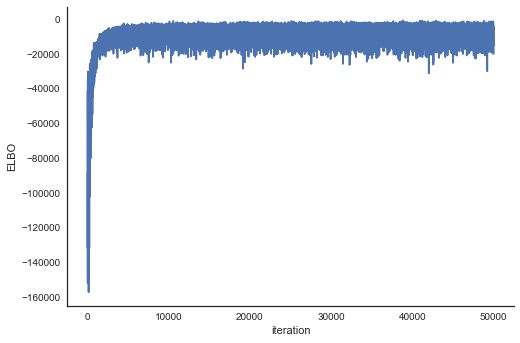

In [60]:
HLM1.plot_elbo()

In [61]:
summary(HLM1.advi_trace)


mu_alpha:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  2.707            2.681            0.033            [-2.503, 7.875]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -2.479         0.924          2.682          4.527          7.913


mu_beta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  7.489            4.976            0.057            [-2.638, 16.969]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -2.346         4.162          7.456          10.849         17.359


alpha:

  Mean             SD               MC Error         95% HPD interval
  ----------------

In [62]:
alphas

array([ 1.15856219,  4.02812109])

In [63]:
betas

array([[  7.49863681,   9.0573482 ],
       [ -2.53113336,  23.23233084]])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x103410050>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x13f1e56d0>]], dtype=object)

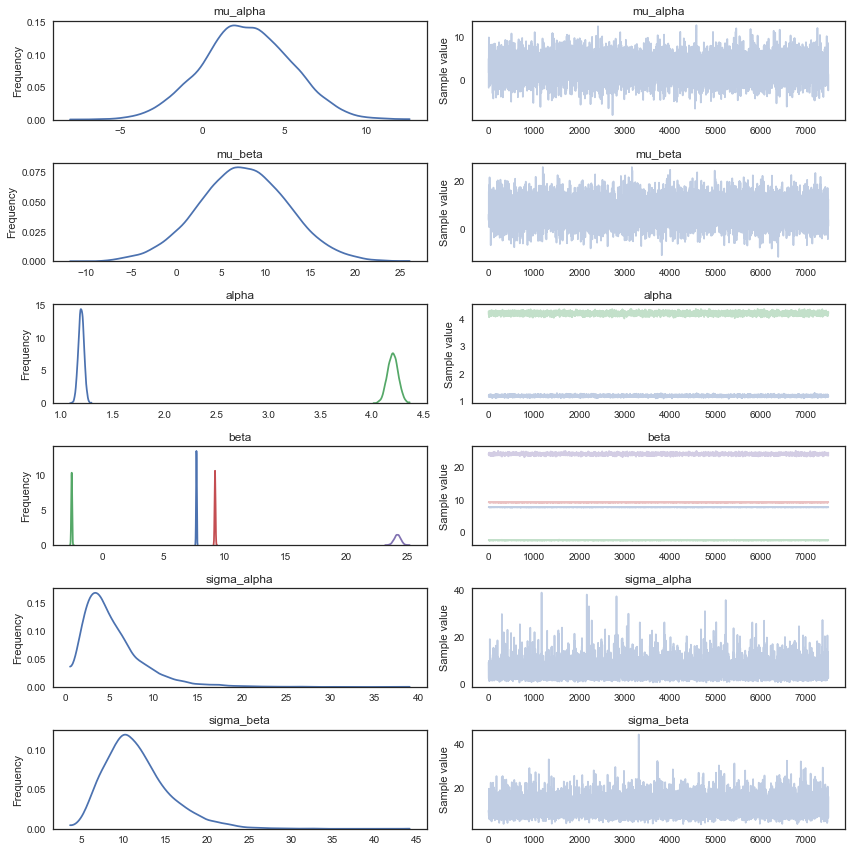

In [64]:
traceplot(HLM1.advi_trace)

<h2> Next Steps </h2>
* Build Bayesian Model base class 
* Pass more options to the init function
* Test if this class can be used in an sklearn pipeline


<h2> Thanks: </h2>
- Daniel Little
- Tudor Radoaca
- Nico Sandller
- PyData Chicago

<h3>
@parsing_science <br>
github.com/parsing-science
</h3>